In [275]:
import pandas as pd
from sklearn.model_selection import train_test_split
# !python -m pip install transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW

# !python -m pip install torch
import torch

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

## Prepare dataset

In [276]:

df = pd.read_csv('severity_dataset.csv', delimiter=';')

# Convert severity labels to numerical values
label_mapping = {'S0': 0, 'S1': 1, 'S2': 2, 'S3': 3}
df['label'] = df['severity'].map(label_mapping)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

train_encodings = tokenizer(train_df['detailed_scenario'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['detailed_scenario'].tolist(), truncation=True, padding=True, max_length=128)

# Convert labels to tensors
train_labels = torch.tensor(train_df['label'].tolist())
val_labels = torch.tensor(val_df['label'].tolist())


## Define the BERT Model and Training Loop

In [277]:
num_epochs = 5

In [278]:
from torch.utils.data import Dataset, DataLoader

class HazardDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HazardDataset(train_encodings, train_labels)
val_dataset = HazardDataset(val_encodings, val_labels)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.train()

# Training parameters
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
optimizer = AdamW(model.parameters(), lr=5e-5)
# optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):  
    model.train()
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    true_labels = []
    output_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            predictions = outputs.logits.argmax(dim=1)
            correct += (predictions == inputs['labels']).sum().item()
            total += len(inputs['labels'])

            true_labels.extend(labels.cpu().numpy())
            output_labels.extend(predictions.cpu().numpy())
            
    val_loss /= len(val_loader)
    accuracy = correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, output_labels, average='weighted')
        
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch 1, Validation Loss: 0.8846717029809952, Accuracy: 0.7265625, Precision: 0.7271322661947662, Recall: 0.7265625, F1: 0.7258272058823529
Epoch 2, Validation Loss: 0.44720007479190826, Accuracy: 0.8515625, Precision: 0.8882808413251961, Recall: 0.8515625, F1: 0.8592930288092183
Epoch 3, Validation Loss: 0.40237386152148247, Accuracy: 0.828125, Precision: 0.857081043956044, Recall: 0.828125, F1: 0.8296327074810053
Epoch 4, Validation Loss: 0.3682972062379122, Accuracy: 0.8515625, Precision: 0.867847278852128, Recall: 0.8515625, F1: 0.8550643241167435
Epoch 5, Validation Loss: 0.3845731499604881, Accuracy: 0.890625, Precision: 0.8952743902439024, Recall: 0.890625, F1: 0.8891443545039435


## Save model and use for prediction

In [279]:
# Save the model
model.save_pretrained('bert_hazard_classifier')
tokenizer.save_pretrained('bert_hazard_classifier')

# Load the model for inference
model = BertForSequenceClassification.from_pretrained('bert_hazard_classifier')
tokenizer = BertTokenizer.from_pretrained('bert_hazard_classifier')

# Function to make predictions
def predict_severity(description):
    inputs = tokenizer(description, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = outputs.logits.argmax(dim=1).item()
    severity_mapping = {0: 'S0', 1: 'S1', 2: 'S2', 3: 'S3'}
    return severity_mapping[prediction]


In [280]:
# description = "Driving in a multi-lane one-way street with adjacent parking lanes and dotted line markings, a pedestrian suddenly crosses the road" #S0
# description = "Navigating a residential street with parked cars on both sides" #S1
# description = "Approaching a T-intersection with yield signs, a motorcycle is coming from the opposite direction" #S2
# description = "Sharp downhill curve with low friction due to wet road conditions and a pedestrian crossing" #S3

description = "Approaching a T-intersection with a debris on the road" #S0

severity = predict_severity(description)
print(f"The predicted severity is: {severity}")


The predicted severity is: S0


## Evaluation

In [281]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
!python -m pip install seaborn
import seaborn as sns

def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(model.device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(model.device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [282]:
# Assuming `val_dataset` is your validation dataset and `model` is your trained BERT model
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Get predictions and true labels
predictions, true_labels = get_predictions(model, val_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print(conf_matrix)


[[35  2  0  1]
 [ 0 34  0  0]
 [ 0  4 17  3]
 [ 0  1  3 28]]


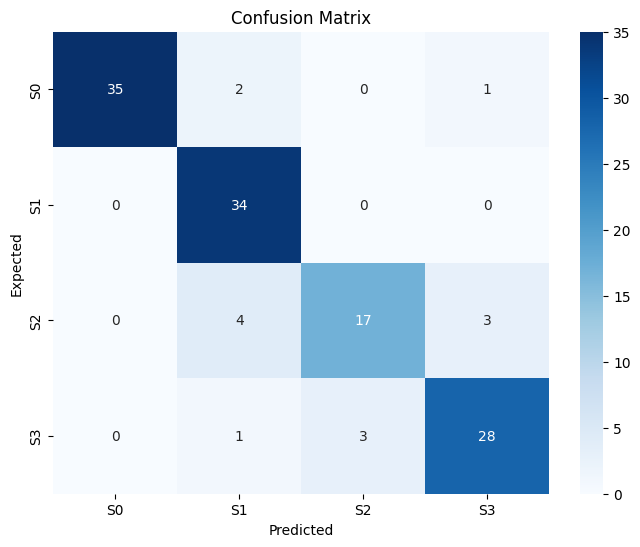

In [283]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.pdf')
    plt.show()

# Assuming you have 4 classes: S0, S1, S2, S3
class_names = ['S0', 'S1', 'S2', 'S3']
plot_confusion_matrix(conf_matrix, class_names)



In [284]:
report = classification_report(val_labels, predictions, target_names=['S0', 'S1', 'S2', 'S3'])
print(report)

              precision    recall  f1-score   support

          S0       1.00      0.92      0.96        38
          S1       0.83      1.00      0.91        34
          S2       0.85      0.71      0.77        24
          S3       0.88      0.88      0.88        32

    accuracy                           0.89       128
   macro avg       0.89      0.88      0.88       128
weighted avg       0.90      0.89      0.89       128

